In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/home/raroog/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class TrialSolution(tf.keras.models.Model):
  def __init__(self, conditions, n_i, n_h, n_o=1, activation='sigmoid', equation_type='ODE'):
    super(TrialSolution, self).__init__()
    self.n_i = n_i
    self.n_h = n_h
    self.n_o = n_o
    self.conditions = conditions
    self.hidden_layer = tf.keras.layers.Dense(units=self.n_h, activation=activation)
    self.output_layer = tf.keras.layers.Dense(units=self.n_o, activation='linear')
    
  def call(self, X):
    X = tf.convert_to_tensor(X)
    response = self.hidden_layer(X)
    response = self.output_layer(response)
    x = tf.reshape(X[:,0], shape=(response.shape[0],1))
    y = tf.reshape(X[:,1], shape=(response.shape[0],1))
    e_1 = tf.constant(np.exp(-1.), dtype='float64', shape=(X.shape[0],1))
    one = tf.constant(1., dtype='float64', shape=(response.shape[0],1))
    response *= x * (one - x)
    response *= y * (one - y)
    response += (one - x) * y **3
    response += x*(one + y**3)*e_1
    response += (one - y) * x * (tf.exp(-x)-e_1)
    response += y *((one + x) * tf.exp(-x) - one + x
                    - tf.constant(2*np.exp(-1), dtype='float64', shape=(X.shape[0],1)) * x )
#     boundary_value = tf.constant(0., dtype='float64', shape=(response.shape[0],1))
    
#     for condition in self.conditions:
#       vanishing = tf.constant(1., dtype='float64', shape=(response.shape[0],1))
#       temp_bc = 0
#       if condition['type'] == 'dirichlet':
#         temp_bc = tf.reshape(condition['function'](X), shape=(response.shape[0],1))           
#         for vanisher in self.conditions:
#           if vanisher['variable'] != condition['variable'] and vanisher['value'] != condition['value']:
#             if vanisher['type'] == 'dirichlet':
#               vanishing *= (X[:, vanisher['variable']]
#                                         - tf.constant(vanisher['value'], dtype='float64', shape=(response.shape[0],1)))
#             elif vanisher['type'] == 'neumann':
#               vanishing *= (X[:, vanisher['variable']]
#                                         - tf.constant(vanisher['value'], dtype='float64', shape=(response.shape[0],1)))
#         boundary_value += temp_bc * vanishing
#         response *= (tf.constant(condition['value'], dtype='float64', shape=(response.shape[0],1))
#                      - tf.reshape(X[:, condition['variable']], shape=(response.shape[0],1)))
#       elif condition['type'] == 'neumann':
#         temp_bc = (tf.reshape(condition['function'](X), shape=(response.shape[0],1))
#                    * tf.reshape(X[:, condition['variable']], shape=(response.shape[0],1)))
#         boundary_value = temp_bc
#         response *= (tf.constant(condition['value'], dtype='float64', shape=(response.shape[0],1))
#                      - tf.reshape(X[:, condition['variable']], shape=(response.shape[0],1)))  
#     response += boundary_value
    return response

In [3]:
bcs = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':lambda X: X[:,1]**3},
        {'variable':0, 'value':0, 'type':'dirichlet',
        'function':lambda X: (tf.constant(1., dtype='float64', shape=(X.shape[0],1))+ X[:,1]**3)*tf.exp(tf.constant(-1., dtype='float64', shape=(X.shape[0],1)))},
        {'variable':1, 'value':0, 'type':'dirichlet',
        'function':lambda X: X[:,0]*tf.exp(-X[:,0])},
        {'variable':1, 'value':1, 'type':'dirichlet',
        'function':lambda X: (X[:,0]+tf.constant(1., dtype='float64', shape=(X.shape[0],1)))*tf.exp(-X[:,0])}]

In [4]:
n_samples = 10
X_p = np.linspace(0, 1, n_samples)
Y_p = np.linspace(0, 1, n_samples)
X_p, Y_p = np.meshgrid(X_p, Y_p)
X_p = X_p.flatten()
Y_p = Y_p.flatten()
samples = np.array([X_p, Y_p]).T

In [5]:
ts = TrialSolution(conditions=bcs, n_i=2, n_h=10, n_o=1)

In [6]:
def diff_loss(network, inputs):
  with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
      inputs = tf.convert_to_tensor(inputs)
      tape.watch(inputs)
      tape2.watch(inputs)
      response = network(inputs)  
    grads = tape.gradient(response, inputs)
  laplace = tape2.gradient(grads, inputs)
#   print(grads)
#   print(laplace)
  two = tf.constant(2, dtype='float64')
  loss = tf.square(laplace[:,0] + laplace[:,1]
                   - tf.exp(-inputs[:,0])*(inputs[:,0] - two  + inputs[:,1]**3 + inputs[:,1]))
  return loss

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
train_loss = tf.keras.metrics.Mean('train')

In [8]:
@tf.function
def train_step(X):
  for i in X:
    with tf.GradientTape() as tape:
      loss = diff_loss(ts, tf.reshape(i, shape=(1, X.shape[1])))
    gradients = tape.gradient(loss, ts.trainable_variables)
    optimizer.apply_gradients(zip(gradients, ts.trainable_variables))
  train_loss(diff_loss(ts, X))

In [9]:
ts(tf.convert_to_tensor(samples))

<tf.Tensor: id=123, shape=(100, 1), dtype=float64, numpy=
array([[0.        ],
       [0.09942659],
       [0.17794165],
       [0.23884377],
       [0.28496906],
       [0.3187519 ],
       [0.34227808],
       [0.3573312 ],
       [0.36543315],
       [0.36787944],
       [0.00137174],
       [0.09878622],
       [0.17581108],
       [0.23570887],
       [0.28129328],
       [0.31498792],
       [0.33887763],
       [0.35475325],
       [0.36415052],
       [0.36838408],
       [0.01097394],
       [0.10559595],
       [0.18045442],
       [0.23875227],
       [0.28325745],
       [0.31635992],
       [0.34012125],
       [0.35631782],
       [0.36647833],
       [0.37191653],
       [0.03703704],
       [0.12738311],
       [0.19872743],
       [0.25418976],
       [0.29646897],
       [0.32789826],
       [0.3504933 ],
       [0.36599389],
       [0.37590027],
       [0.38150461],
       [0.0877915 ],
       [0.17167511],
       [0.23748594],
       [0.28823713],
       [0.32653508

In [10]:
EPOCHS = 1000
for epoch in range(EPOCHS):
  train_step(samples)
  if (epoch+1) % 1 == 0:
    print(f'Epoch: {epoch+1} Loss: {train_loss.result().numpy()}')

Epoch: 1 Loss: 0.24575300514698029
Epoch: 2 Loss: 0.2999962270259857
Epoch: 3 Loss: 0.3089948892593384
Epoch: 4 Loss: 0.3129829466342926
Epoch: 5 Loss: 0.3154240846633911
Epoch: 6 Loss: 0.3171463906764984
Epoch: 7 Loss: 0.3184520900249481
Epoch: 8 Loss: 0.31949159502983093
Epoch: 9 Loss: 0.32035136222839355
Epoch: 10 Loss: 0.32108381390571594
Epoch: 11 Loss: 0.3217220902442932
Epoch: 12 Loss: 0.3222880959510803
Epoch: 13 Loss: 0.32279708981513977
Epoch: 14 Loss: 0.323260098695755
Epoch: 15 Loss: 0.3236856162548065
Epoch: 16 Loss: 0.324080228805542
Epoch: 17 Loss: 0.3244493305683136
Epoch: 18 Loss: 0.3247971534729004
Epoch: 19 Loss: 0.3251273036003113
Epoch: 20 Loss: 0.3254425525665283
Epoch: 21 Loss: 0.32574525475502014
Epoch: 22 Loss: 0.3260371685028076
Epoch: 23 Loss: 0.32631975412368774
Epoch: 24 Loss: 0.3265939950942993
Epoch: 25 Loss: 0.32686081528663635
Epoch: 26 Loss: 0.32712072134017944
Epoch: 27 Loss: 0.3273741602897644
Epoch: 28 Loss: 0.3276214003562927
Epoch: 29 Loss: 0.3278

Epoch: 232 Loss: 0.33334025740623474
Epoch: 233 Loss: 0.3333415985107422
Epoch: 234 Loss: 0.33334293961524963
Epoch: 235 Loss: 0.3333442807197571
Epoch: 236 Loss: 0.33334556221961975
Epoch: 237 Loss: 0.3333468437194824
Epoch: 238 Loss: 0.3333481252193451
Epoch: 239 Loss: 0.3333493769168854
Epoch: 240 Loss: 0.33335059881210327
Epoch: 241 Loss: 0.3333517909049988
Epoch: 242 Loss: 0.3333529829978943
Epoch: 243 Loss: 0.3333541452884674
Epoch: 244 Loss: 0.3333553075790405
Epoch: 245 Loss: 0.33335644006729126
Epoch: 246 Loss: 0.3333575427532196
Epoch: 247 Loss: 0.33335867524147034
Epoch: 248 Loss: 0.3333597779273987
Epoch: 249 Loss: 0.33336082100868225
Epoch: 250 Loss: 0.3333618640899658
Epoch: 251 Loss: 0.3333629071712494
Epoch: 252 Loss: 0.33336395025253296
Epoch: 253 Loss: 0.33336496353149414
Epoch: 254 Loss: 0.33336594700813293
Epoch: 255 Loss: 0.33336693048477173
Epoch: 256 Loss: 0.33336788415908813
Epoch: 257 Loss: 0.33336883783340454
Epoch: 258 Loss: 0.33336979150772095
Epoch: 259 Los

Epoch: 459 Loss: 0.3334306478500366
Epoch: 460 Loss: 0.3334307074546814
Epoch: 461 Loss: 0.33343076705932617
Epoch: 462 Loss: 0.33343082666397095
Epoch: 463 Loss: 0.3334308862686157
Epoch: 464 Loss: 0.3334309458732605
Epoch: 465 Loss: 0.3334309756755829
Epoch: 466 Loss: 0.33343103528022766
Epoch: 467 Loss: 0.33343109488487244
Epoch: 468 Loss: 0.3334311544895172
Epoch: 469 Loss: 0.333431214094162
Epoch: 470 Loss: 0.33343127369880676
Epoch: 471 Loss: 0.33343133330345154
Epoch: 472 Loss: 0.3334313631057739
Epoch: 473 Loss: 0.3334314227104187
Epoch: 474 Loss: 0.3334314823150635
Epoch: 475 Loss: 0.33343154191970825
Epoch: 476 Loss: 0.333431601524353
Epoch: 477 Loss: 0.3334316313266754
Epoch: 478 Loss: 0.3334316909313202
Epoch: 479 Loss: 0.33343175053596497
Epoch: 480 Loss: 0.33343181014060974
Epoch: 481 Loss: 0.3334318697452545
Epoch: 482 Loss: 0.3334318995475769
Epoch: 483 Loss: 0.3334319591522217
Epoch: 484 Loss: 0.33343201875686646
Epoch: 485 Loss: 0.33343207836151123
Epoch: 486 Loss: 0.

Epoch: 687 Loss: 0.33343467116355896
Epoch: 688 Loss: 0.33343467116355896
Epoch: 689 Loss: 0.33343467116355896
Epoch: 690 Loss: 0.33343467116355896
Epoch: 691 Loss: 0.33343467116355896
Epoch: 692 Loss: 0.33343467116355896
Epoch: 693 Loss: 0.33343467116355896
Epoch: 694 Loss: 0.33343467116355896
Epoch: 695 Loss: 0.33343470096588135
Epoch: 696 Loss: 0.33343470096588135
Epoch: 697 Loss: 0.33343470096588135
Epoch: 698 Loss: 0.33343470096588135
Epoch: 699 Loss: 0.33343470096588135
Epoch: 700 Loss: 0.33343470096588135
Epoch: 701 Loss: 0.33343470096588135
Epoch: 702 Loss: 0.33343473076820374
Epoch: 703 Loss: 0.33343473076820374
Epoch: 704 Loss: 0.33343473076820374
Epoch: 705 Loss: 0.33343473076820374
Epoch: 706 Loss: 0.33343473076820374
Epoch: 707 Loss: 0.33343473076820374
Epoch: 708 Loss: 0.33343473076820374
Epoch: 709 Loss: 0.33343473076820374
Epoch: 710 Loss: 0.3334347605705261
Epoch: 711 Loss: 0.3334347605705261
Epoch: 712 Loss: 0.3334347605705261
Epoch: 713 Loss: 0.3334347605705261
Epoch

Epoch: 915 Loss: 0.3334353566169739
Epoch: 916 Loss: 0.3334353566169739
Epoch: 917 Loss: 0.3334353566169739
Epoch: 918 Loss: 0.33343538641929626
Epoch: 919 Loss: 0.33343538641929626
Epoch: 920 Loss: 0.33343538641929626
Epoch: 921 Loss: 0.33343538641929626
Epoch: 922 Loss: 0.33343538641929626
Epoch: 923 Loss: 0.33343538641929626
Epoch: 924 Loss: 0.33343538641929626
Epoch: 925 Loss: 0.33343538641929626
Epoch: 926 Loss: 0.33343538641929626
Epoch: 927 Loss: 0.33343538641929626
Epoch: 928 Loss: 0.33343538641929626
Epoch: 929 Loss: 0.33343538641929626
Epoch: 930 Loss: 0.33343538641929626
Epoch: 931 Loss: 0.33343541622161865
Epoch: 932 Loss: 0.33343541622161865
Epoch: 933 Loss: 0.33343541622161865
Epoch: 934 Loss: 0.33343541622161865
Epoch: 935 Loss: 0.33343541622161865
Epoch: 936 Loss: 0.33343541622161865
Epoch: 937 Loss: 0.33343541622161865
Epoch: 938 Loss: 0.33343541622161865
Epoch: 939 Loss: 0.33343541622161865
Epoch: 940 Loss: 0.33343541622161865
Epoch: 941 Loss: 0.33343541622161865
Epoc

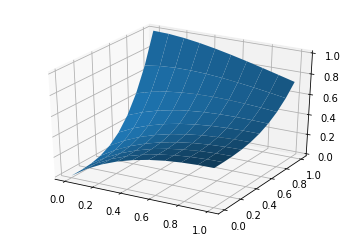

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
new_shape = int(np.sqrt(samples.shape[0]))
Ze5sol = tf.reshape(ts(samples), shape=(samples.shape[0],)).numpy()
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze5sol.reshape((new_shape, new_shape)), label='Numerical - Training')
plt.show()

/home/raroog/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


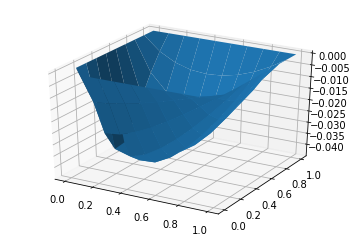

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Ze5anal = (samples[:,0] + samples[:,1]**3) * np.exp(-samples[:, 0])
Ze5diff = (Ze5sol - Ze5anal)/Ze5anal
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze5diff.reshape((new_shape, new_shape)), label='Analytic')
# plt.legend()
plt.show()

In [13]:
np.abs(Ze5diff).mean()

nan

In [14]:
np.max(Ze5diff)

nan

In [15]:
a = tf.convert_to_tensor(np.random.random(size=(10,2)))

In [16]:
a

<tf.Tensor: id=11839, shape=(10, 2), dtype=float64, numpy=
array([[0.84381454, 0.69563016],
       [0.3803453 , 0.14164087],
       [0.68316428, 0.55411545],
       [0.62584003, 0.54880833],
       [0.95652393, 0.85352083],
       [0.45860744, 0.34087968],
       [0.25306414, 0.59533185],
       [0.43888318, 0.73010877],
       [0.09080061, 0.91675455],
       [0.45737718, 0.86150069]])>

In [17]:
for i in a: 
  print(i)

tf.Tensor([0.84381454 0.69563016], shape=(2,), dtype=float64)
tf.Tensor([0.3803453  0.14164087], shape=(2,), dtype=float64)
tf.Tensor([0.68316428 0.55411545], shape=(2,), dtype=float64)
tf.Tensor([0.62584003 0.54880833], shape=(2,), dtype=float64)
tf.Tensor([0.95652393 0.85352083], shape=(2,), dtype=float64)
tf.Tensor([0.45860744 0.34087968], shape=(2,), dtype=float64)
tf.Tensor([0.25306414 0.59533185], shape=(2,), dtype=float64)
tf.Tensor([0.43888318 0.73010877], shape=(2,), dtype=float64)
tf.Tensor([0.09080061 0.91675455], shape=(2,), dtype=float64)
tf.Tensor([0.45737718 0.86150069], shape=(2,), dtype=float64)


In [ ]:
tf.cont